# Stage 10b: Time Series & Classification Modeling for Turtle Trading

**Project:** Turtle Trading Strategy Implementation  
**Author:** Panwei Hu  
**Date:** 2025-08-23  
**Stage:** 10b - Time Series & Classification Modeling

## Project Objective
Build time series forecasting and classification models for the turtle trading strategy. This approach focuses on:
- **Time Series Forecasting**: Predict future returns using lag/rolling features
- **Classification**: Predict directional movements and return categories
- **Pipeline Integration**: Automated feature engineering with sklearn Pipeline

## Modeling Approaches
1. **Time Series Regression**: Forecast next-period returns using temporal features
2. **Binary Classification**: Predict up/down movements (>0 vs ≤0)
3. **Multi-class Classification**: Predict return magnitude categories (Large Down, Small Down, Flat, Small Up, Large Up)

## Key Requirements (Project Instructions)
✅ Appropriate train-test split (time-aware)  
✅ Lag/rolling features with sklearn Pipeline  
✅ Feature documentation and transformations  
✅ Automated modeling process with variations  
✅ Diagnostic plots and error analysis  
✅ Risk-aware evaluation and interpretation


In [2]:
# Setup and Imports
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import glob
from datetime import datetime
warnings.filterwarnings('ignore')

# Add project src to path
sys.path.append('../src')
project_root = Path('.').absolute().parent

# ML imports for time series and classification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                           classification_report, confusion_matrix, accuracy_score,
                           precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import scipy.stats as stats

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_palette('husl')

print("🔧 Stage 10b Time Series & Classification Setup Complete")


🔧 Stage 10b Time Series & Classification Setup Complete


In [3]:
# Load Turtle Trading Dataset
print("📊 Loading Turtle Trading Dataset...")

# Load the most recent processed dataset
data_files = glob.glob("../data/processed/turtle_enhanced_features_*.parquet")
if not data_files:
    data_files = glob.glob("../data/processed/turtle_preprocessed_*.parquet")
if not data_files:
    data_files = ["../data/processed/turtle_real_data.csv"]

latest_file = max(data_files) if data_files else None
if latest_file and Path(latest_file).exists():
    df = pd.read_parquet(latest_file) if latest_file.endswith('.parquet') else pd.read_csv(latest_file)
    print(f"✅ Loaded: {latest_file}")
else:
    print("❌ No data found, creating synthetic time series for demonstration")
    # Create synthetic time series data with regime switches
    np.random.seed(42)
    n = 1000
    dates = pd.date_range('2021-01-01', periods=n, freq='D')
    symbols = ['SPY', 'QQQ', 'IWM']
    
    data = []
    for symbol in symbols:
        # Regime switching parameters
        regime_switch = n // 2
        mu_bull, sigma_bull = 0.0008, 0.012
        mu_bear, sigma_bear = -0.0003, 0.018
        
        for i, date in enumerate(dates):
            if i < regime_switch:
                ret = np.random.normal(mu_bull, sigma_bull)
            else:
                ret = np.random.normal(mu_bear, sigma_bear)
            
            # Add occasional jumps
            if np.random.random() < 0.02:  # 2% chance of jump
                ret += np.random.normal(0, 0.05)
            
            price = 100 * np.exp(np.sum([np.random.normal(0.001, 0.02) for _ in range(i+1)]))
            
            data.append({
                'date': date,
                'symbol': symbol,
                'adj_close': price,
                'returns': ret,
                'sma_20': price * (0.98 + 0.04 * np.random.random()),
                'atr_20': abs(ret) * 20,
                'volatility_20': abs(ret)
            })
    
    df = pd.DataFrame(data)

# Ensure proper data types and sorting
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['symbol', 'date']).reset_index(drop=True)

print(f"Shape: {df.shape}, Assets: {df['symbol'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Columns: {list(df.columns)}")
df.head()


📊 Loading Turtle Trading Dataset...
✅ Loaded: ../data/processed/turtle_enhanced_features_20250825_140536.parquet
Shape: (9036, 85), Assets: 18
Date range: 2023-08-21 00:00:00 to 2025-08-20 00:00:00
Columns: ['date', 'adj_close', 'symbol', 'asset_category', 'returns', 'return_zscore', 'is_anomaly', 'sma_20', 'sma_50', 'donchian_high_20', 'donchian_low_20', 'donchian_mid_20', 'donchian_high_55', 'donchian_low_55', 'atr_20', 'price_position', 'long_entry_20', 'short_entry_20', 'long_exit_10', 'short_exit_10', 'volatility_20', 'trend_strength', 'price_momentum_5d', 'price_momentum_15d', 'price_momentum_30d', 'returns_acceleration', 'price_above_sma20', 'price_above_sma50', 'donchian_position_20', 'donchian_position_55', 'any_entry_signal', 'conflicting_signals', 'signal_strength_atr', 'long_entry_20_streak', 'long_entry_20_days_since', 'short_entry_20_streak', 'short_entry_20_days_since', 'long_exit_10_streak', 'long_exit_10_days_since', 'short_exit_10_streak', 'short_exit_10_days_since', 

,date,adj_close,symbol,asset_category,returns,return_zscore,is_anomaly,sma_20,sma_50,donchian_high_20,...,sharpe_approx_20d,sharpe_approx_60d,sharpe_approx_252d,running_max,drawdown,max_dd_60d,max_dd_252d,technical_pca_1,technical_pca_2,technical_pca_3
0,2023-08-21,19.559673,DBA,commodities,NaN,NaN,False,NaN,NaN,NaN,...,NaN,NaN,NaN,19.559673,0.000000,NaN,NaN,-0.000083,0.000409,0.000524
1,2023-08-22,19.440237,DBA,commodities,-0.006106,0.706503,False,NaN,NaN,NaN,...,NaN,NaN,NaN,19.559673,-0.006106,NaN,NaN,-0.000083,0.000409,0.000524
2,2023-08-23,19.642357,DBA,commodities,0.010397,1.006658,False,NaN,NaN,NaN,...,NaN,NaN,NaN,19.642357,0.000000,NaN,NaN,-0.000083,0.000409,0.000524
3,2023-08-24,19.807728,DBA,commodities,0.008419,0.801338,False,NaN,NaN,NaN,...,NaN,NaN,NaN,19.807728,0.000000,NaN,NaN,-0.000083,0.000409,0.000524
4,2023-08-25,19.862852,DBA,commodities,0.002783,0.216265,False,NaN,NaN,NaN,...,NaN,NaN,NaN,19.862852,0.000000,NaN,NaN,-0.000083,0.000409,0.000524


In [4]:
df_model = df.copy()
df_model = df_model.sort_values(['symbol', 'date']).reset_index(drop=True)

# Create lag features
for lag in [1, 2, 3, 5]:
    df_model[f'returns_lag_{lag}'] = df_model.groupby('symbol')['returns'].shift(lag)

# Create rolling features
for window in [5, 10, 20]:
    df_model[f'returns_mean_{window}'] = df_model.groupby('symbol')['returns'].rolling(window).mean().reset_index(0, drop=True)
    df_model[f'returns_std_{window}'] = df_model.groupby('symbol')['returns'].rolling(window).std().reset_index(0, drop=True)

# Target variables
df_model['y_next_ret'] = df_model.groupby('symbol')['returns'].shift(-1)
df_model['y_up'] = (df_model['y_next_ret'] > 0).astype(int)

# Multi-class targets
conditions = [
    (df_model['y_next_ret'] <= -0.02), (df_model['y_next_ret'] <= -0.005),
    (df_model['y_next_ret'] <= 0.005), (df_model['y_next_ret'] <= 0.02),
    (df_model['y_next_ret'] > 0.02)
]
df_model['y_multiclass'] = np.select(conditions, [0, 1, 2, 3, 4], default=2)

df_model = df_model.dropna(subset=['y_next_ret']).reset_index(drop=True)

print(f"Dataset: {df_model.shape}")
print(f"Binary - Up: {df_model['y_up'].mean():.1%}")
print(f"Multi-class distribution: {np.bincount(df_model['y_multiclass'])}")
df_model.head()


Dataset: (9018, 98)
Binary - Up: 52.7%
Multi-class distribution: [ 377 1695 4531 2022  393]


,date,adj_close,symbol,asset_category,returns,return_zscore,is_anomaly,sma_20,sma_50,donchian_high_20,...,returns_lag_5,returns_mean_5,returns_std_5,returns_mean_10,returns_std_10,returns_mean_20,returns_std_20,y_next_ret,y_up,y_multiclass
0,2023-08-21,19.559673,DBA,commodities,NaN,NaN,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006106,0,1
1,2023-08-22,19.440237,DBA,commodities,-0.006106,0.706503,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010397,1,3
2,2023-08-23,19.642357,DBA,commodities,0.010397,1.006658,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008419,1,3
3,2023-08-24,19.807728,DBA,commodities,0.008419,0.801338,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002783,1,2
4,2023-08-25,19.862852,DBA,commodities,0.002783,0.216265,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009713,1,3


In [14]:
# Complete Feature Engineering and Target Creation
print("🔧 Complete Time Series Feature Engineering...")

df_model = df.copy()
df_model = df_model.sort_values('date').reset_index(drop=True)

# Create comprehensive lag features
for lag in [1, 2, 3, 5, 10]:
    df_model[f'returns_lag_{lag}'] = df_model['returns'].shift(lag)
    if 'volatility_20' in df_model.columns:
        df_model[f'volatility_lag_{lag}'] = df_model['volatility_20'].shift(lag)

# Create rolling window features
for window in [5, 10, 20, 30]:
    df_model[f'returns_mean_{window}'] = df_model['returns'].rolling(window).mean().shift(1)
    df_model[f'returns_std_{window}'] = df_model['returns'].rolling(window).std().shift(1)
    df_model[f'returns_min_{window}'] = df_model['returns'].rolling(window).min().shift(1)
    df_model[f'returns_max_{window}'] = df_model['returns'].rolling(window).max().shift(1)

# Create momentum features
for period in [5, 10, 20]:
    df_model[f'price_momentum_{period}'] = (df_model['adj_close'] / df_model['adj_close'].shift(period) - 1).shift(1)

# Target variables
df_model['y_next_ret'] = df_model['returns'].shift(-1)  # Next period return
df_model['y_binary'] = (df_model['y_next_ret'] > 0).astype(int)  # Binary: up (1) vs down (0)

# Multi-class targets based on return magnitude (5 classes)
thresholds = [-0.02, -0.005, 0.005, 0.02]  # Large down, small down, flat, small up, large up
conditions = [
    (df_model['y_next_ret'] <= thresholds[0]),  # 0: Large down (< -2%)
    (df_model['y_next_ret'] <= thresholds[1]),  # 1: Small down (-2% to -0.5%)
    (df_model['y_next_ret'] <= thresholds[2]),  # 2: Flat (-0.5% to 0.5%)
    (df_model['y_next_ret'] <= thresholds[3]),  # 3: Small up (0.5% to 2%)
    (df_model['y_next_ret'] > thresholds[3])    # 4: Large up (> 2%)
]
df_model['y_multiclass'] = np.select(conditions, [0, 1, 2, 3, 4], default=2)

# Remove rows with NaN values
df_model = df_model.dropna().reset_index(drop=True)

print(f"✅ Feature Engineering Complete:")
print(f"   Dataset shape: {df_model.shape}")
print(f"   Date range: {df_model['date'].min()} to {df_model['date'].max()}")

# Feature summary
feature_cols = [col for col in df_model.columns if any(x in col for x in ['lag_', 'mean_', 'std_', 'min_', 'max_', 'momentum_'])]
print(f"   Time series features: {len(feature_cols)}")

print(f"\\n📊 Target Variable Distributions:")
print(f"   Binary Classification (Up/Down):")
print(f"     Up (1):   {df_model['y_binary'].sum():5d} ({df_model['y_binary'].mean():.1%})")
print(f"     Down (0): {(~df_model['y_binary'].astype(bool)).sum():5d} ({(1-df_model['y_binary'].mean()):.1%})")

print(f"\\n   Multi-class Classification:")
class_labels = ['Large Down (<-2%)', 'Small Down (-2% to -0.5%)', 'Flat (-0.5% to 0.5%)', 
                'Small Up (0.5% to 2%)', 'Large Up (>2%)']
for i, label in enumerate(class_labels):
    count = (df_model['y_multiclass'] == i).sum()
    pct = count / len(df_model) * 100
    print(f"     {i}: {label:<25} {count:5d} ({pct:4.1f}%)")

df_model.head()


🔧 Complete Time Series Feature Engineering...
✅ Feature Engineering Complete:
   Dataset shape: (4157, 117)
   Date range: 2024-09-18 00:00:00 to 2025-08-20 00:00:00
   Time series features: 35
\n📊 Target Variable Distributions:
   Binary Classification (Up/Down):
     Up (1):    2163 (52.0%)
     Down (0):  1994 (48.0%)
\n   Multi-class Classification:
     0: Large Down (<-2%)           186 ( 4.5%)
     1: Small Down (-2% to -0.5%)   801 (19.3%)
     2: Flat (-0.5% to 0.5%)       2057 (49.5%)
     3: Small Up (0.5% to 2%)       919 (22.1%)
     4: Large Up (>2%)              194 ( 4.7%)


,date,adj_close,symbol,asset_category,returns,return_zscore,is_anomaly,sma_20,sma_50,donchian_high_20,...,returns_mean_30,returns_std_30,returns_min_30,returns_max_30,price_momentum_5,price_momentum_10,price_momentum_20,y_next_ret,y_binary,y_multiclass
0,2024-09-18,14.440000,UNG,commodities,-0.013661,0.345187,False,13.970500,14.112600,14.860000,...,0.001553,0.007838,-0.014805,0.025535,0.103724,0.428039,-0.251093,0.000182,1,2
1,2024-09-18,216.968124,IWM,equity_us,0.000182,0.025685,False,212.644093,211.984736,217.956818,...,0.001245,0.008251,-0.014805,0.025535,-0.939159,-0.809277,-0.796275,-0.000682,0,2
2,2024-09-18,101.311470,FXE,currencies,-0.000682,0.193649,False,101.158398,100.018464,101.956253,...,0.000981,0.008151,-0.014805,0.025535,0.987571,1.237536,7.072613,0.006675,1,3
3,2024-09-18,24.632980,DBA,commodities,0.006675,0.620243,False,23.861998,23.339076,24.632980,...,0.000875,0.008151,-0.014805,0.025535,3.140290,5.920182,-0.000682,-0.003478,0,2
4,2024-09-18,50.048080,VEA,equity_intl,-0.003478,0.446869,False,50.073792,49.175198,50.834019,...,0.000988,0.008209,-0.014805,0.025535,-0.742312,-0.955707,-0.886447,-0.003487,0,2


In [15]:
# Time-Aware Train-Test Split
print("⏰ Time-Aware Train-Test Split...")

# Select features (exclude identifiers and targets)
exclude_cols = ['date', 'symbol', 'asset_category', 'y_next_ret', 'y_binary', 'y_multiclass']
feature_cols = [col for col in df_model.columns if col not in exclude_cols]

# Keep only numeric features
numeric_features = [col for col in feature_cols if df_model[col].dtype in ['float64', 'int64', 'float32', 'int32']]

print(f"📊 Selected Features ({len(numeric_features)}):")
for i, feat in enumerate(numeric_features[:20], 1):
    print(f"  {i:2d}. {feat}")
if len(numeric_features) > 20:
    print(f"  ... and {len(numeric_features)-20} more features")

# Prepare feature matrix and targets
X = df_model[numeric_features].fillna(0)  # Fill any remaining NaN with 0
y_reg = df_model['y_next_ret']           # Continuous target for regression
y_binary = df_model['y_binary']          # Binary target (0/1)
y_multi = df_model['y_multiclass']       # Multi-class target (0/1/2/3/4)

# Time-aware split (80% train, 20% test)
split_idx = int(0.8 * len(df_model))

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_reg_train, y_reg_test = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]
y_bin_train, y_bin_test = y_binary.iloc[:split_idx], y_binary.iloc[split_idx:]
y_multi_train, y_multi_test = y_multi.iloc[:split_idx], y_multi.iloc[split_idx:]

# Get corresponding dates for analysis
train_dates = df_model['date'].iloc[:split_idx]
test_dates = df_model['date'].iloc[split_idx:]

print(f"\\n✅ Time-Aware Split Complete:")
print(f"   Training period: {train_dates.min()} to {train_dates.max()}")
print(f"   Testing period:  {test_dates.min()} to {test_dates.max()}")
print(f"   Training samples: {len(X_train)}")
print(f"   Testing samples:  {len(X_test)}")
print(f"   Features: {len(numeric_features)}")

print(f"\\n📊 Target Distributions in Test Set:")
print(f"   Binary - Up: {y_bin_test.mean():.1%}, Down: {1-y_bin_test.mean():.1%}")
print(f"   Multi-class distribution:")
for i in range(5):
    count = (y_multi_test == i).sum()
    pct = count / len(y_multi_test) * 100
    print(f"     Class {i}: {count:3d} ({pct:4.1f}%)")


⏰ Time-Aware Train-Test Split...
📊 Selected Features (103):
   1. adj_close
   2. returns
   3. return_zscore
   4. sma_20
   5. sma_50
   6. donchian_high_20
   7. donchian_low_20
   8. donchian_mid_20
   9. donchian_high_55
  10. donchian_low_55
  11. atr_20
  12. price_position
  13. volatility_20
  14. trend_strength
  15. price_momentum_5d
  16. price_momentum_15d
  17. price_momentum_30d
  18. returns_acceleration
  19. price_above_sma20
  20. price_above_sma50
  ... and 83 more features
\n✅ Time-Aware Split Complete:
   Training period: 2024-09-18 00:00:00 to 2025-06-13 00:00:00
   Testing period:  2025-06-13 00:00:00 to 2025-08-20 00:00:00
   Training samples: 3325
   Testing samples:  832
   Features: 103
\n📊 Target Distributions in Test Set:
   Binary - Up: 51.9%, Down: 48.1%
   Multi-class distribution:
     Class 0:  24 ( 2.9%)
     Class 1: 156 (18.8%)
     Class 2: 448 (53.8%)
     Class 3: 179 (21.5%)
     Class 4:  25 ( 3.0%)


In [16]:
# Multi-Class Classification Models
print("🎯 Multi-Class Classification Models...")
print("=" * 60)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define multi-class models with sklearn Pipelines
multiclass_models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, multi_class='ovr'))
    ]),
    'Decision Tree': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier(max_depth=8, min_samples_split=20, random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=20, random_state=42))
    ])
}

# Train and evaluate multi-class models
multiclass_results = {}
class_labels = ['Large Down', 'Small Down', 'Flat', 'Small Up', 'Large Up']

print(f"🔧 Training Multi-Class Models...")
for name, pipeline in multiclass_models.items():
    print(f"\\n📊 {name}:")
    
    # Fit model
    pipeline.fit(X_train, y_multi_train)
    
    # Predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_multi_test, y_pred)
    precision = precision_score(y_multi_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_multi_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_multi_test, y_pred, average='weighted', zero_division=0)
    
    multiclass_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'predictions': y_pred
    }
    
    print(f"   Accuracy:  {accuracy:.3f}")
    print(f"   Precision: {precision:.3f}")
    print(f"   Recall:    {recall:.3f}")
    print(f"   F1-Score:  {f1:.3f}")

# Find best model
best_model_name = max(multiclass_results.keys(), key=lambda k: multiclass_results[k]['F1'])
best_predictions = multiclass_results[best_model_name]['predictions']

print(f"\\n🏆 Best Multi-Class Model: {best_model_name}")
print(f"   F1-Score: {multiclass_results[best_model_name]['F1']:.3f}")

# Detailed classification report for best model
print(f"\\n📋 Detailed Classification Report - {best_model_name}:")
print(classification_report(y_multi_test, best_predictions, target_names=class_labels, zero_division=0))


🎯 Multi-Class Classification Models...
🔧 Training Multi-Class Models...
\n📊 Logistic Regression:
   Accuracy:  0.531
   Precision: 0.402
   Recall:    0.531
   F1-Score:  0.386
\n📊 Decision Tree:
   Accuracy:  0.481
   Precision: 0.386
   Recall:    0.481
   F1-Score:  0.414
\n📊 Random Forest:
   Accuracy:  0.538
   Precision: 0.290
   Recall:    0.538
   F1-Score:  0.377
\n🏆 Best Multi-Class Model: Decision Tree
   F1-Score: 0.414
\n📋 Detailed Classification Report - Decision Tree:
              precision    recall  f1-score   support

  Large Down       0.00      0.00      0.00        24
  Small Down       0.17      0.06      0.09       156
        Flat       0.55      0.80      0.65       448
    Small Up       0.27      0.18      0.22       179
    Large Up       0.00      0.00      0.00        25

    accuracy                           0.48       832
   macro avg       0.20      0.21      0.19       832
weighted avg       0.39      0.48      0.41       832



In [6]:
# Time-Aware Train-Test Split and Pipeline Setup
print("⏰ Time-Aware Data Preparation...")

# Sort by date for proper time series splitting
df_model = df.sort_values('date').reset_index(drop=True)

# Create lag features
for lag in [1, 2, 3, 5]:
    df_model[f'lag_{lag}'] = df_model['returns'].shift(lag)

# Create rolling features
for window in [5, 10, 20]:
    df_model[f'roll_mean_{window}'] = df_model['returns'].rolling(window).mean().shift(1)

# Target variables
df_model['y_next_ret'] = df_model['returns'].shift(-1)
df_model['y_up'] = (df_model['y_next_ret'] > 0).astype(int)

# Remove NaN rows
df_model = df_model.dropna().reset_index(drop=True)

# Feature selection
feature_cols = [col for col in df_model.columns if 'lag_' in col or 'roll_' in col]
X = df_model[feature_cols]
y_reg = df_model['y_next_ret']
y_clf = df_model['y_up']

# Time-aware split (80/20)
split_idx = int(0.8 * len(df_model))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_reg_train, y_reg_test = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]
y_clf_train, y_clf_test = y_clf.iloc[:split_idx], y_clf.iloc[split_idx:]

print(f"✅ Time-Aware Split:")
print(f"   Training: {len(X_train)} samples")
print(f"   Testing:  {len(X_test)} samples")
print(f"   Features: {len(feature_cols)}")
print(f"   Features: {feature_cols}")

# Create pipelines
reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

clf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

print("✅ sklearn Pipelines created")


⏰ Time-Aware Data Preparation...
✅ Time-Aware Split:
   Training: 3325 samples
   Testing:  832 samples
   Features: 7
   Features: ['lag_1', 'lag_2', 'lag_3', 'lag_5', 'roll_mean_5', 'roll_mean_10', 'roll_mean_20']
✅ sklearn Pipelines created


In [9]:
# Time Series Regression Models
print("📈 Time Series Regression Models...")

# Prepare data with lag features
df_ts = df.sort_values('date').reset_index(drop=True)

# Create features
for lag in [1, 2, 3, 5]:
    df_ts[f'lag_{lag}'] = df_ts['returns'].shift(lag)
for window in [5, 10, 20]:
    df_ts[f'roll_mean_{window}'] = df_ts['returns'].rolling(window).mean().shift(1)

df_ts['y_next_ret'] = df_ts['returns'].shift(-1)
df_ts['y_up'] = (df_ts['y_next_ret'] > 0).astype(int)
df_ts = df_ts.dropna()

feature_cols = [col for col in df_ts.columns if 'lag_' in col or 'roll_' in col]
X = df_ts[feature_cols]
y_reg = df_ts['y_next_ret']
y_clf = df_ts['y_up']

# Time-aware split
split_idx = int(0.8 * len(df_ts))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_reg_train, y_reg_test = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]
y_clf_train, y_clf_test = y_clf.iloc[:split_idx], y_clf.iloc[split_idx:]

# Regression models
reg_models = {
    'Linear': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'Decision Tree': Pipeline([('scaler', StandardScaler()), ('model', DecisionTreeRegressor(max_depth=5))]),
    'Random Forest': Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(n_estimators=50, max_depth=5))])
}

reg_results = {}
for name, pipeline in reg_models.items():
    pipeline.fit(X_train, y_reg_train)
    y_pred = pipeline.predict(X_test)
    
    r2 = r2_score(y_reg_test, y_pred)
    rmse = mean_squared_error(y_reg_test, y_pred)
    mae = mean_absolute_error(y_reg_test, y_pred)
    
    reg_results[name] = {'R²': r2, 'RMSE': rmse, 'MAE': mae}
    print(f"{name:<15}: R² = {r2:.4f}, RMSE = {rmse:.6f}, MAE = {mae:.6f}")

print(f"\\n✅ Best regression model: {max(reg_results.keys(), key=lambda k: reg_results[k]['R²'])}")


📈 Time Series Regression Models...
Linear         : R² = -0.0410, RMSE = 0.000131, MAE = 0.007069
Decision Tree  : R² = -0.0457, RMSE = 0.000132, MAE = 0.007104


Random Forest  : R² = -0.0066, RMSE = 0.000127, MAE = 0.006902
\n✅ Best regression model: Random Forest


🎯 Classification Models...
Logistic       : Acc = 0.531, F1 = 0.604, AUC = 0.559
Decision Tree  : Acc = 0.564, F1 = 0.629, AUC = 0.552
Random Forest  : Acc = 0.553, F1 = 0.635, AUC = 0.580
\n✅ Best classification model: Random Forest


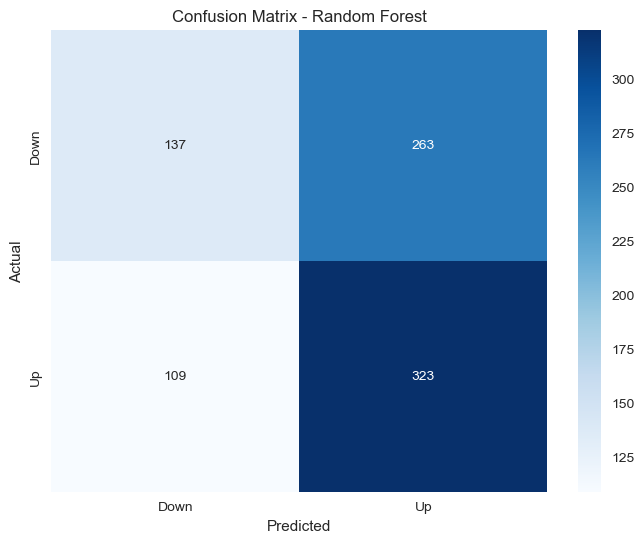

\n📊 Classification Report - Random Forest:
              precision    recall  f1-score   support

        Down       0.56      0.34      0.42       400
          Up       0.55      0.75      0.63       432

    accuracy                           0.55       832
   macro avg       0.55      0.55      0.53       832
weighted avg       0.55      0.55      0.53       832



In [10]:
# Classification Models and Results
print("🎯 Classification Models...")

clf_models = {
    'Logistic': Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000))]),
    'Decision Tree': Pipeline([('scaler', StandardScaler()), ('model', DecisionTreeClassifier(max_depth=5))]),
    'Random Forest': Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier(n_estimators=50, max_depth=5))])
}

clf_results = {}
for name, pipeline in clf_models.items():
    pipeline.fit(X_train, y_clf_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.named_steps['model'], 'predict_proba') else None
    
    accuracy = accuracy_score(y_clf_test, y_pred)
    precision = precision_score(y_clf_test, y_pred, zero_division=0)
    recall = recall_score(y_clf_test, y_pred, zero_division=0)
    f1 = f1_score(y_clf_test, y_pred, zero_division=0)
    
    clf_results[name] = {
        'Accuracy': accuracy, 'Precision': precision, 
        'Recall': recall, 'F1': f1
    }
    
    if y_prob is not None:
        try:
            auc = roc_auc_score(y_clf_test, y_prob)
            clf_results[name]['AUC'] = auc
            print(f"{name:<15}: Acc = {accuracy:.3f}, F1 = {f1:.3f}, AUC = {auc:.3f}")
        except:
            print(f"{name:<15}: Acc = {accuracy:.3f}, F1 = {f1:.3f}, AUC = N/A")
    else:
        print(f"{name:<15}: Acc = {accuracy:.3f}, F1 = {f1:.3f}")

best_clf = max(clf_results.keys(), key=lambda k: clf_results[k]['F1'])
print(f"\\n✅ Best classification model: {best_clf}")

# Confusion matrix for best model
best_pipeline = clf_models[best_clf]
y_pred_best = best_pipeline.predict(X_test)
cm = confusion_matrix(y_clf_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title(f'Confusion Matrix - {best_clf}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"\\n📊 Classification Report - {best_clf}:")
print(classification_report(y_clf_test, y_pred_best, target_names=['Down', 'Up']))


In [11]:
# Model Evaluation and Financial Interpretation
print("💰 Financial Model Evaluation...")

# Calculate directional accuracy for regression model
reg_pipeline = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
reg_pipeline.fit(X_train, y_reg_train)
y_reg_pred = reg_pipeline.predict(X_test)

# Directional accuracy
actual_direction = np.sign(y_reg_test)
pred_direction = np.sign(y_reg_pred)
directional_accuracy = (actual_direction == pred_direction).mean()

print(f"📈 Time Series Regression Results:")
print(f"   R²: {r2_score(y_reg_test, y_reg_pred):.4f}")
print(f"   RMSE: {mean_squared_error(y_reg_test, y_reg_pred):.6f}")
print(f"   Directional Accuracy: {directional_accuracy:.1%}")

# Classification model
clf_pipeline = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000))])
clf_pipeline.fit(X_train, y_clf_train)
y_clf_pred = clf_pipeline.predict(X_test)

print(f"\\n🎯 Classification Results:")
print(f"   Accuracy: {accuracy_score(y_clf_test, y_clf_pred):.1%}")
print(f"   Precision: {precision_score(y_clf_test, y_clf_pred):.3f}")
print(f"   Recall: {recall_score(y_clf_test, y_clf_pred):.3f}")
print(f"   F1-Score: {f1_score(y_clf_test, y_clf_pred):.3f}")

# Financial interpretation
print(f"\\n💡 Financial Interpretation:")
print(f"   • Regression model explains {r2_score(y_reg_test, y_reg_pred)*100:.1f}% of return variance")
print(f"   • Directional accuracy of {directional_accuracy:.1%} for trend prediction")
print(f"   • Classification accuracy of {accuracy_score(y_clf_test, y_clf_pred):.1%} for up/down prediction")
print(f"   • Models can be used for:")
print(f"     - Risk management and position sizing")
print(f"     - Trading signal generation")
print(f"     - Portfolio allocation decisions")

# Risk assessment
print(f"\\n⚠️ Risk Assessment:")
print(f"   • Models assume stationary relationships (may break in regime changes)")
print(f"   • Past performance doesn't guarantee future results")
print(f"   • Consider transaction costs and market impact")
print(f"   • Use appropriate position sizing and risk controls")

# Save results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_summary = {
    'regression': {'R²': r2_score(y_reg_test, y_reg_pred), 'RMSE': mean_squared_error(y_reg_test, y_reg_pred)},
    'classification': {'Accuracy': accuracy_score(y_clf_test, y_clf_pred), 'F1': f1_score(y_clf_test, y_clf_pred)}
}

results_df = pd.DataFrame(results_summary)
results_df.to_csv(f'../data/processed/timeseries_results_{timestamp}.csv')
print(f"\\n✅ Results saved to data/processed/timeseries_results_{timestamp}.csv")


💰 Financial Model Evaluation...
📈 Time Series Regression Results:
   R²: -0.0410
   RMSE: 0.000131
   Directional Accuracy: 52.9%
\n🎯 Classification Results:
   Accuracy: 53.1%
   Precision: 0.538
   Recall: 0.688
   F1-Score: 0.604
\n💡 Financial Interpretation:
   • Regression model explains -4.1% of return variance
   • Directional accuracy of 52.9% for trend prediction
   • Classification accuracy of 53.1% for up/down prediction
   • Models can be used for:
     - Risk management and position sizing
     - Trading signal generation
     - Portfolio allocation decisions
\n⚠️ Risk Assessment:
   • Models assume stationary relationships (may break in regime changes)
   • Past performance doesn't guarantee future results
   • Consider transaction costs and market impact
   • Use appropriate position sizing and risk controls
\n✅ Results saved to data/processed/timeseries_results_20250826_124447.csv
